# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cha         1206 non-null   int64 
 1   reflex      1206 non-null   int64 
 2   will        1206 non-null   int64 
 3   ac          1206 non-null   int64 
 4   con         1206 non-null   int64 
 5   dex         1206 non-null   int64 
 6   str         1206 non-null   int64 
 7   hp          1206 non-null   int64 
 8   fortitude   1206 non-null   int64 
 9   level       1206 non-null   int64 
 10  book        1206 non-null   object
 11  wis         1206 non-null   int64 
 12  int         1206 non-null   int64 
 13  perception  1206 non-null   int64 
 14  focus       1206 non-null   int32 
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [3]:
df.head()

,cha,reflex,will,ac,con,dex,str,hp,fortitude,level,book,wis,int,perception,focus
0,1,19,17,29,5,2,7,215,22,10,Pathfinder Bestiary,2,1,20,1
1,1,14,16,28,5,0,9,220,21,10,Pathfinder Bestiary,2,-4,16,0
2,-2,17,15,25,6,3,7,175,20,8,Pathfinder Bestiary,3,-4,17,0
3,6,29,32,41,5,4,7,315,30,17,Pathfinder Bestiary,5,6,30,1
4,1,10,4,16,1,3,-5,20,6,1,Pathfinder Bestiary,1,-1,6,1


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


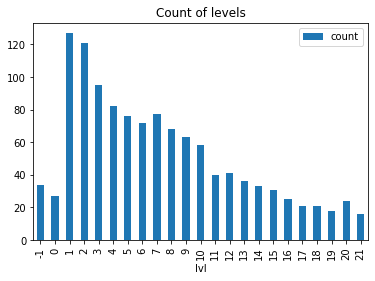

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 13
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.26
RMSE: 0.51
MAE: 0.36


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.21
RMSE test: 0.51


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

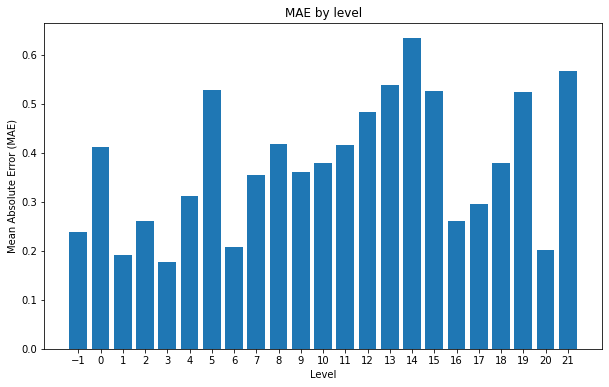

In [18]:
plot_mae_by_level(y_test, y_pred_test)

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.26
RMSE: 0.51

Round type: round
MSE: 0.30
RMSE: 0.55

Round type: 0.33
MSE: 0.29
RMSE: 0.54

Round type: 0.45
MSE: 0.29
RMSE: 0.54



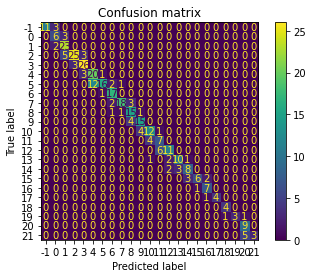

In [20]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-03 20:11:09,836] A new study created in memory with name: no-name-3e0484ac-ba26-4318-bdcc-5d9893791858
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.188025 + 0.0387075
[200]	cv_agg's l2: 0.185962 + 0.0366348


feature_fraction, val_score: 0.185028:   0%|                                                     | 0/7 [00:01<?, ?it/s]

[300]	cv_agg's l2: 0.185649 + 0.0362683
Early stopping, best iteration is:
[242]	cv_agg's l2: 0.185028 + 0.0360569


feature_fraction, val_score: 0.185028:  14%|######4                                      | 1/7 [00:01<00:08,  1.44s/it]

[100]	cv_agg's l2: 0.186056 + 0.0447295
[200]	cv_agg's l2: 0.182449 + 0.042503
[300]	cv_agg's l2: 0.181552 + 0.0419692


feature_fraction, val_score: 0.181247:  29%|############8                                | 2/7 [00:02<00:06,  1.38s/it]

Early stopping, best iteration is:
[292]	cv_agg's l2: 0.181247 + 0.041863
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


feature_fraction, val_score: 0.162080:  43%|###################2                         | 3/7 [00:03<00:04,  1.18s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.1677 + 0.0286543
[200]	cv_agg's l2: 0.163664 + 0.0256416


feature_fraction, val_score: 0.162080:  57%|#########################7                   | 4/7 [00:04<00:03,  1.13s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.181478 + 0.0420344
[200]	cv_agg's l2: 0.176947 + 0.0385135


feature_fraction, val_score: 0.162080:  71%|################################1            | 5/7 [00:05<00:02,  1.13s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.184475 + 0.0378577
[200]	cv_agg's l2: 0.181178 + 0.0367941


feature_fraction, val_score: 0.162080:  86%|######################################5      | 6/7 [00:06<00:01,  1.10s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.168147 + 0.0325914
[200]	cv_agg's l2: 0.16436 + 0.0324772


feature_fraction, val_score: 0.162080: 100%|#############################################| 7/7 [00:07<00:00,  1.13s/it]


Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933


num_leaves, val_score: 0.162080:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:   5%|##5                                               | 1/20 [00:00<00:18,  1.02it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  10%|#####                                             | 2/20 [00:02<00:19,  1.06s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  15%|#######5                                          | 3/20 [00:03<00:18,  1.09s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.18919 + 0.0269691


num_leaves, val_score: 0.162080:  20%|##########                                        | 4/20 [00:03<00:13,  1.22it/s]

[200]	cv_agg's l2: 0.173754 + 0.0230684
Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  25%|############5                                     | 5/20 [00:04<00:14,  1.06it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  30%|###############                                   | 6/20 [00:05<00:12,  1.08it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  35%|#################5                                | 7/20 [00:06<00:11,  1.08it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  40%|####################                              | 8/20 [00:07<00:11,  1.03it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  45%|######################5                           | 9/20 [00:08<00:11,  1.00s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  50%|########################5                        | 10/20 [00:09<00:09,  1.02it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  55%|##########################9                      | 11/20 [00:10<00:08,  1.02it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  60%|#############################4                   | 12/20 [00:11<00:07,  1.02it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  65%|###############################8                 | 13/20 [00:12<00:06,  1.04it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  70%|##################################3              | 14/20 [00:13<00:05,  1.02it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  75%|####################################7            | 15/20 [00:14<00:04,  1.02it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  80%|#######################################2         | 16/20 [00:15<00:03,  1.01it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  85%|#########################################6       | 17/20 [00:16<00:03,  1.03s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  90%|############################################1    | 18/20 [00:17<00:01,  1.00it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080:  95%|##############################################5  | 19/20 [00:18<00:01,  1.00s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


num_leaves, val_score: 0.162080: 100%|#################################################| 20/20 [00:19<00:00,  1.02it/s]


Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933


bagging, val_score: 0.162080:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.187442 + 0.0295799


bagging, val_score: 0.162080:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[200]	cv_agg's l2: 0.179692 + 0.0234563
Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933


bagging, val_score: 0.162080:  10%|#####3                                               | 1/10 [00:00<00:06,  1.40it/s]

[100]	cv_agg's l2: 0.209123 + 0.0326058


bagging, val_score: 0.162080:  20%|##########6                                          | 2/10 [00:01<00:05,  1.47it/s]

[200]	cv_agg's l2: 0.195096 + 0.0309511
Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.17057 + 0.0223891
[200]	cv_agg's l2: 0.16543 + 0.0207222


bagging, val_score: 0.162080:  30%|###############9                                     | 3/10 [00:02<00:05,  1.23it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.200434 + 0.0298072
[200]	cv_agg's l2: 0.189993 + 0.0280076


bagging, val_score: 0.162080:  40%|#####################2                               | 4/10 [00:03<00:04,  1.33it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.174294 + 0.03551
[200]	cv_agg's l2: 0.170572 + 0.0343893


bagging, val_score: 0.162080:  50%|##########################5                          | 5/10 [00:03<00:04,  1.22it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.185633 + 0.032594


bagging, val_score: 0.162080:  50%|##########################5                          | 5/10 [00:04<00:04,  1.22it/s]

[200]	cv_agg's l2: 0.181461 + 0.025221
Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933


bagging, val_score: 0.162080:  60%|###############################8                     | 6/10 [00:04<00:03,  1.28it/s]

[100]	cv_agg's l2: 0.203941 + 0.0464746


bagging, val_score: 0.162080:  60%|###############################8                     | 6/10 [00:05<00:03,  1.28it/s]

[200]	cv_agg's l2: 0.194604 + 0.0447128
Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933


bagging, val_score: 0.162080:  70%|#####################################                | 7/10 [00:05<00:02,  1.35it/s]

[100]	cv_agg's l2: 0.177488 + 0.0346777
[200]	cv_agg's l2: 0.173912 + 0.0299511


bagging, val_score: 0.162080:  80%|##########################################4          | 8/10 [00:06<00:01,  1.20it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.204678 + 0.0428073
[200]	cv_agg's l2: 0.19367 + 0.0420885


bagging, val_score: 0.162080:  90%|###############################################7     | 9/10 [00:07<00:00,  1.23it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.185685 + 0.0437121
[200]	cv_agg's l2: 0.178542 + 0.0391924


bagging, val_score: 0.162080: 100%|####################################################| 10/10 [00:08<00:00,  1.25it/s]


Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933


feature_fraction_stage2, val_score: 0.162080:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.170741 + 0.0332744
[200]	cv_agg's l2: 0.165927 + 0.0329852


feature_fraction_stage2, val_score: 0.162080:  17%|######3                               | 1/6 [00:00<00:04,  1.18it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.168147 + 0.0325914
[200]	cv_agg's l2: 0.16436 + 0.0324772


feature_fraction_stage2, val_score: 0.162080:  33%|############6                         | 2/6 [00:01<00:03,  1.08it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.170741 + 0.0332744
[200]	cv_agg's l2: 0.165927 + 0.0329852


feature_fraction_stage2, val_score: 0.162080:  50%|###################                   | 3/6 [00:02<00:03,  1.02s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


feature_fraction_stage2, val_score: 0.162080:  67%|#########################3            | 4/6 [00:03<00:02,  1.01s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.1677 + 0.0286543
[200]	cv_agg's l2: 0.163664 + 0.0256416


feature_fraction_stage2, val_score: 0.162080:  83%|###############################6      | 5/6 [00:04<00:00,  1.01it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167278 + 0.0306286
[200]	cv_agg's l2: 0.162426 + 0.0294347


feature_fraction_stage2, val_score: 0.162080: 100%|######################################| 6/6 [00:06<00:00,  1.00s/it]


Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933


regularization_factors, val_score: 0.162080:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.167801 + 0.0305183
[200]	cv_agg's l2: 0.163036 + 0.02933


regularization_factors, val_score: 0.162080:   5%|#9                                    | 1/20 [00:01<00:21,  1.13s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.217363 + 0.0435408
[200]	cv_agg's l2: 0.211348 + 0.0427826


regularization_factors, val_score: 0.162080:  10%|###8                                  | 2/20 [00:01<00:12,  1.41it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167801 + 0.0305183
[200]	cv_agg's l2: 0.162962 + 0.0293105


regularization_factors, val_score: 0.162080:  15%|#####7                                | 3/20 [00:02<00:15,  1.13it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.172453 + 0.0319161
[200]	cv_agg's l2: 0.168726 + 0.0313565


regularization_factors, val_score: 0.162080:  20%|#######6                              | 4/20 [00:03<00:14,  1.08it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.166456 + 0.0303537
[200]	cv_agg's l2: 0.163263 + 0.0296962


regularization_factors, val_score: 0.162080:  25%|#########5                            | 5/20 [00:04<00:14,  1.04it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167985 + 0.0309063
[200]	cv_agg's l2: 0.163726 + 0.0304133


regularization_factors, val_score: 0.162080:  30%|###########4                          | 6/20 [00:05<00:13,  1.04it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.175887 + 0.0331913
[200]	cv_agg's l2: 0.168288 + 0.0306715


regularization_factors, val_score: 0.162080:  35%|#############3                        | 7/20 [00:06<00:12,  1.05it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933


regularization_factors, val_score: 0.162080:  40%|###############2                      | 8/20 [00:06<00:09,  1.29it/s]

[100]	cv_agg's l2: 0.227694 + 0.046553
[200]	cv_agg's l2: 0.225442 + 0.046595
Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.17115 + 0.0312281
[200]	cv_agg's l2: 0.167414 + 0.0301175


regularization_factors, val_score: 0.162080:  45%|#################1                    | 9/20 [00:07<00:09,  1.19it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167801 + 0.0305183
[200]	cv_agg's l2: 0.163323 + 0.0296825


regularization_factors, val_score: 0.162080:  50%|##################5                  | 10/20 [00:09<00:09,  1.08it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.169095 + 0.0288037
[200]	cv_agg's l2: 0.164937 + 0.0276056


regularization_factors, val_score: 0.162080:  55%|####################3                | 11/20 [00:10<00:08,  1.03it/s]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167855 + 0.0301475
[200]	cv_agg's l2: 0.162719 + 0.0285335


regularization_factors, val_score: 0.162080:  60%|######################2              | 12/20 [00:11<00:08,  1.08s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167801 + 0.0305183
[200]	cv_agg's l2: 0.162962 + 0.0293104


regularization_factors, val_score: 0.162080:  65%|########################             | 13/20 [00:12<00:07,  1.06s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.169078 + 0.0322099
[200]	cv_agg's l2: 0.165843 + 0.031507


regularization_factors, val_score: 0.162080:  70%|#########################9           | 14/20 [00:13<00:06,  1.06s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.172177 + 0.0305684
[200]	cv_agg's l2: 0.169251 + 0.0272854


regularization_factors, val_score: 0.162080:  75%|###########################7         | 15/20 [00:14<00:05,  1.09s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.171543 + 0.0282438
[200]	cv_agg's l2: 0.166673 + 0.0256765


regularization_factors, val_score: 0.162080:  80%|#############################6       | 16/20 [00:15<00:04,  1.06s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.166879 + 0.0303076
[200]	cv_agg's l2: 0.163193 + 0.0307023


regularization_factors, val_score: 0.162080:  85%|###############################4     | 17/20 [00:16<00:03,  1.04s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167808 + 0.03051
[200]	cv_agg's l2: 0.163019 + 0.0292448


regularization_factors, val_score: 0.162080:  90%|#################################3   | 18/20 [00:17<00:02,  1.05s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167111 + 0.0313597
[200]	cv_agg's l2: 0.163085 + 0.0299651


regularization_factors, val_score: 0.162080:  95%|###################################1 | 19/20 [00:18<00:01,  1.03s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.16208 + 0.0287933
[100]	cv_agg's l2: 0.167002 + 0.0293737
[200]	cv_agg's l2: 0.162517 + 0.0280984


regularization_factors, val_score: 0.161975: 100%|#####################################| 20/20 [00:19<00:00,  1.01it/s]


[300]	cv_agg's l2: 0.162957 + 0.0277767
Early stopping, best iteration is:
[210]	cv_agg's l2: 0.161975 + 0.0277709


min_data_in_leaf, val_score: 0.161975:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.182546 + 0.0379344
[200]	cv_agg's l2: 0.176225 + 0.0336663


min_data_in_leaf, val_score: 0.161975:  20%|#########                                    | 1/5 [00:01<00:04,  1.07s/it]

[300]	cv_agg's l2: 0.174124 + 0.0318125
Early stopping, best iteration is:
[210]	cv_agg's l2: 0.161975 + 0.0277709
[100]	cv_agg's l2: 0.24881 + 0.0551348
[200]	cv_agg's l2: 0.233803 + 0.058675


min_data_in_leaf, val_score: 0.161975:  40%|##################                           | 2/5 [00:01<00:02,  1.24it/s]

[300]	cv_agg's l2: 0.22931 + 0.0575174
Early stopping, best iteration is:
[210]	cv_agg's l2: 0.161975 + 0.0277709
[100]	cv_agg's l2: 0.153935 + 0.0332636
[200]	cv_agg's l2: 0.151859 + 0.0339897


min_data_in_leaf, val_score: 0.151465:  60%|###########################                  | 3/5 [00:03<00:02,  1.12s/it]

Early stopping, best iteration is:
[183]	cv_agg's l2: 0.151465 + 0.0338603
[100]	cv_agg's l2: 0.158844 + 0.0308041
[200]	cv_agg's l2: 0.157209 + 0.0308974


min_data_in_leaf, val_score: 0.151465:  80%|####################################         | 4/5 [00:05<00:01,  1.43s/it]

Early stopping, best iteration is:
[183]	cv_agg's l2: 0.151465 + 0.0338603
[100]	cv_agg's l2: 0.756582 + 0.111112


min_data_in_leaf, val_score: 0.151465:  80%|####################################         | 4/5 [00:05<00:01,  1.43s/it]

[200]	cv_agg's l2: 0.734948 + 0.120452
Early stopping, best iteration is:
[183]	cv_agg's l2: 0.151465 + 0.0338603


min_data_in_leaf, val_score: 0.151465: 100%|#############################################| 5/5 [00:05<00:00,  1.13s/it]


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.1514651087579832
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.00013874032033382792
    lambda_l2: 8.447915375498709e-08
    num_leaves: 31
    feature_fraction: 0.5
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.49
MSE test: 0.24
MAE test: 0.34



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

###### MAE by level

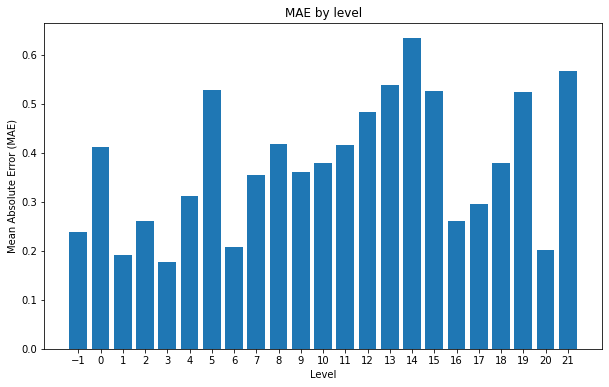

In [27]:
plot_mae_by_level(y_test, y_pred_test)

In [28]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.24
RMSE: 0.49

Round type: round
MSE: 0.27
RMSE: 0.52

Round type: 0.33
MSE: 0.28
RMSE: 0.53

Round type: 0.45
MSE: 0.28
RMSE: 0.53



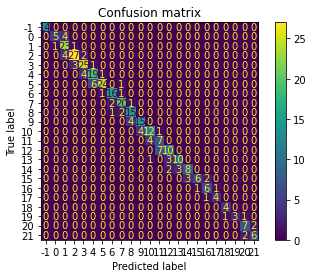

In [29]:
plot_confusion_matrix("round", predict, y_test)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 13
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 0.148111	valid_0's l1: 0.267273


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.15
RMSE: 0.38
MAE: 0.27


In [33]:
results.loc[2] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

###### MAE by level

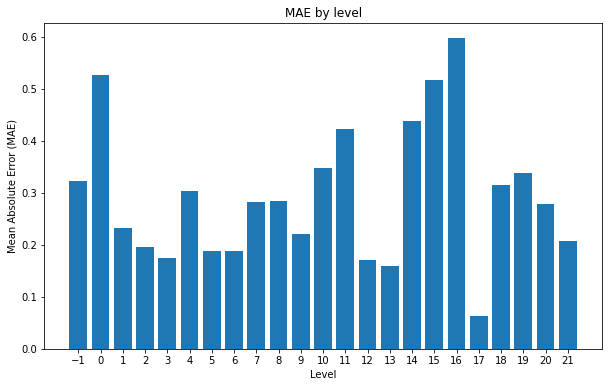

In [34]:
plot_mae_by_level(y_test_random_split, y_pred_test)

In [35]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.15
RMSE: 0.38

Round type: round
MSE: 0.15
RMSE: 0.39

Round type: 0.33
MSE: 0.21
RMSE: 0.45

Round type: 0.45
MSE: 0.17
RMSE: 0.41



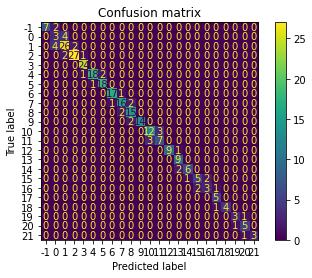

In [36]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-03 20:12:28,203] A new study created in memory with name: no-name-b89d79ac-7c4a-42b9-909b-64f8adfd1269
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.178884 + 0.0483631
[200]	cv_agg's l2: 0.175873 + 0.0445969


feature_fraction, val_score: 0.175474:  14%|######4                                      | 1/7 [00:02<00:15,  2.53s/it]

Early stopping, best iteration is:
[184]	cv_agg's l2: 0.175474 + 0.0448178
[100]	cv_agg's l2: 0.187548 + 0.05778
[200]	cv_agg's l2: 0.185614 + 0.0555841


feature_fraction, val_score: 0.175474:  29%|############8                                | 2/7 [00:04<00:12,  2.44s/it]

Early stopping, best iteration is:
[184]	cv_agg's l2: 0.175474 + 0.0448178
[100]	cv_agg's l2: 0.194867 + 0.0452702
[200]	cv_agg's l2: 0.1921 + 0.0433405


feature_fraction, val_score: 0.175474:  43%|###################2                         | 3/7 [00:07<00:10,  2.50s/it]

Early stopping, best iteration is:
[184]	cv_agg's l2: 0.175474 + 0.0448178
[100]	cv_agg's l2: 0.181142 + 0.0425803
[200]	cv_agg's l2: 0.179121 + 0.0378852


feature_fraction, val_score: 0.175474:  57%|#########################7                   | 4/7 [00:10<00:07,  2.54s/it]

Early stopping, best iteration is:
[184]	cv_agg's l2: 0.175474 + 0.0448178
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


feature_fraction, val_score: 0.168374:  71%|################################1            | 5/7 [00:12<00:04,  2.42s/it]

Early stopping, best iteration is:
[167]	cv_agg's l2: 0.168374 + 0.0330971
[100]	cv_agg's l2: 0.198518 + 0.0577839
[200]	cv_agg's l2: 0.195345 + 0.054818


feature_fraction, val_score: 0.168374:  86%|######################################5      | 6/7 [00:14<00:02,  2.46s/it]

Early stopping, best iteration is:
[167]	cv_agg's l2: 0.168374 + 0.0330971
[100]	cv_agg's l2: 0.187598 + 0.0552958
[200]	cv_agg's l2: 0.184353 + 0.0515492


feature_fraction, val_score: 0.168374: 100%|#############################################| 7/7 [00:17<00:00,  2.54s/it]


Early stopping, best iteration is:
[167]	cv_agg's l2: 0.168374 + 0.0330971


num_leaves, val_score: 0.168374:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.168374:   5%|##5                                               | 1/20 [00:03<01:06,  3.53s/it]

Early stopping, best iteration is:
[167]	cv_agg's l2: 0.168374 + 0.0330971
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.168374:  10%|#####                                             | 2/20 [00:06<00:53,  3.00s/it]

Early stopping, best iteration is:
[167]	cv_agg's l2: 0.168374 + 0.0330971
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.168374:  15%|#######5                                          | 3/20 [00:08<00:45,  2.67s/it]

Early stopping, best iteration is:
[167]	cv_agg's l2: 0.168374 + 0.0330971
[100]	cv_agg's l2: 0.164436 + 0.0430786
[200]	cv_agg's l2: 0.163426 + 0.0387529


num_leaves, val_score: 0.162713:  20%|##########                                        | 4/20 [00:09<00:35,  2.21s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.31537 + 0.0640844


num_leaves, val_score: 0.162713:  25%|############5                                     | 5/20 [00:10<00:23,  1.56s/it]

[200]	cv_agg's l2: 0.281572 + 0.0531207
Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.162713:  30%|###############                                   | 6/20 [00:13<00:27,  1.96s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.184446 + 0.0335765


num_leaves, val_score: 0.162713:  30%|###############                                   | 6/20 [00:13<00:27,  1.96s/it]

[200]	cv_agg's l2: 0.175765 + 0.0278821
Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455


num_leaves, val_score: 0.162713:  35%|#################5                                | 7/20 [00:13<00:20,  1.59s/it]

[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.162713:  40%|####################                              | 8/20 [00:16<00:22,  1.89s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.162713:  45%|######################5                           | 9/20 [00:19<00:23,  2.13s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.162713:  50%|########################5                        | 10/20 [00:21<00:22,  2.23s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.162713:  55%|##########################9                      | 11/20 [00:24<00:21,  2.36s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.162713:  60%|#############################4                   | 12/20 [00:26<00:19,  2.46s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.162713:  65%|###############################8                 | 13/20 [00:29<00:18,  2.60s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.162713:  70%|##################################3              | 14/20 [00:32<00:15,  2.52s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.162713:  75%|####################################7            | 15/20 [00:34<00:12,  2.49s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.162713:  80%|#######################################2         | 16/20 [00:37<00:10,  2.65s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.162713:  85%|#########################################6       | 17/20 [00:40<00:08,  2.74s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.162713:  90%|############################################1    | 18/20 [00:43<00:05,  2.85s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.162713:  95%|##############################################5  | 19/20 [00:46<00:02,  2.82s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169124 + 0.0369588
[200]	cv_agg's l2: 0.168887 + 0.0328139


num_leaves, val_score: 0.162713: 100%|#################################################| 20/20 [00:49<00:00,  2.46s/it]


Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455


bagging, val_score: 0.162713:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.202046 + 0.0417112
[200]	cv_agg's l2: 0.19394 + 0.0351835


bagging, val_score: 0.162713:  10%|#####3                                               | 1/10 [00:01<00:14,  1.61s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.167411 + 0.0385568
[200]	cv_agg's l2: 0.167293 + 0.0350508


bagging, val_score: 0.162713:  20%|##########6                                          | 2/10 [00:03<00:13,  1.70s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169523 + 0.0370379
[200]	cv_agg's l2: 0.16775 + 0.0339228


bagging, val_score: 0.162713:  30%|###############9                                     | 3/10 [00:04<00:11,  1.65s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.171607 + 0.0391753
[200]	cv_agg's l2: 0.170191 + 0.0359219


bagging, val_score: 0.162713:  40%|#####################2                               | 4/10 [00:06<00:09,  1.66s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.167753 + 0.0414078
[200]	cv_agg's l2: 0.164595 + 0.0372595


bagging, val_score: 0.162713:  50%|##########################5                          | 5/10 [00:08<00:08,  1.73s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.167484 + 0.0388929
[200]	cv_agg's l2: 0.166615 + 0.0354264


bagging, val_score: 0.162713:  60%|###############################8                     | 6/10 [00:10<00:06,  1.73s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.169391 + 0.0401964
[200]	cv_agg's l2: 0.167335 + 0.0360307


bagging, val_score: 0.162713:  70%|#####################################                | 7/10 [00:12<00:05,  1.80s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.170454 + 0.0376468
[200]	cv_agg's l2: 0.166374 + 0.0341124


bagging, val_score: 0.162713:  80%|##########################################4          | 8/10 [00:13<00:03,  1.80s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.174976 + 0.0402312
[200]	cv_agg's l2: 0.169541 + 0.0345021


bagging, val_score: 0.162713:  90%|###############################################7     | 9/10 [00:15<00:01,  1.81s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.175225 + 0.0402055
[200]	cv_agg's l2: 0.171956 + 0.0336881


bagging, val_score: 0.162713: 100%|####################################################| 10/10 [00:17<00:00,  1.77s/it]


Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455


feature_fraction_stage2, val_score: 0.162713:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.17019 + 0.0367981
[200]	cv_agg's l2: 0.165618 + 0.0317333


feature_fraction_stage2, val_score: 0.162713:  33%|############6                         | 1/3 [00:01<00:03,  1.63s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.164436 + 0.0430786
[200]	cv_agg's l2: 0.163426 + 0.0387529


feature_fraction_stage2, val_score: 0.162713:  67%|#########################3            | 2/3 [00:03<00:01,  1.57s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.17019 + 0.0367981
[200]	cv_agg's l2: 0.165618 + 0.0317333


feature_fraction_stage2, val_score: 0.162713: 100%|######################################| 3/3 [00:04<00:00,  1.57s/it]


Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455


regularization_factors, val_score: 0.162713:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.166863 + 0.036082
[200]	cv_agg's l2: 0.163138 + 0.0311351


regularization_factors, val_score: 0.162713:   5%|#9                                    | 1/20 [00:01<00:29,  1.57s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.168398 + 0.0419792
[200]	cv_agg's l2: 0.165857 + 0.0389804


regularization_factors, val_score: 0.162713:  10%|###8                                  | 2/20 [00:03<00:29,  1.61s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.177569 + 0.0348432
[200]	cv_agg's l2: 0.169736 + 0.0307907


regularization_factors, val_score: 0.162713:  15%|#####7                                | 3/20 [00:05<00:28,  1.70s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.196151 + 0.0495352


regularization_factors, val_score: 0.162713:  20%|#######6                              | 4/20 [00:05<00:22,  1.40s/it]

[200]	cv_agg's l2: 0.192222 + 0.047536
Early stopping, best iteration is:
[173]	cv_agg's l2: 0.162713 + 0.0388455
[100]	cv_agg's l2: 0.163951 + 0.0429873
[200]	cv_agg's l2: 0.163023 + 0.0390509


regularization_factors, val_score: 0.162624:  25%|#########5                            | 5/20 [00:07<00:23,  1.55s/it]

Early stopping, best iteration is:
[176]	cv_agg's l2: 0.162624 + 0.0390173
[100]	cv_agg's l2: 0.163771 + 0.0430827
[200]	cv_agg's l2: 0.163101 + 0.0388724


regularization_factors, val_score: 0.162613:  30%|###########4                          | 6/20 [00:09<00:21,  1.55s/it]

Early stopping, best iteration is:
[151]	cv_agg's l2: 0.162613 + 0.0394848
[100]	cv_agg's l2: 0.163921 + 0.0430072
[200]	cv_agg's l2: 0.163397 + 0.0387436


regularization_factors, val_score: 0.162613:  35%|#############3                        | 7/20 [00:11<00:20,  1.59s/it]

Early stopping, best iteration is:
[151]	cv_agg's l2: 0.162613 + 0.0394848
[100]	cv_agg's l2: 0.163951 + 0.0429873
[200]	cv_agg's l2: 0.163023 + 0.0390508


regularization_factors, val_score: 0.162613:  40%|###############2                      | 8/20 [00:12<00:18,  1.58s/it]

Early stopping, best iteration is:
[151]	cv_agg's l2: 0.162613 + 0.0394848
[100]	cv_agg's l2: 0.163951 + 0.0429873
[200]	cv_agg's l2: 0.163397 + 0.0387431


regularization_factors, val_score: 0.162613:  45%|#################1                    | 9/20 [00:14<00:17,  1.55s/it]

Early stopping, best iteration is:
[151]	cv_agg's l2: 0.162613 + 0.0394848
[100]	cv_agg's l2: 0.163951 + 0.0429873
[200]	cv_agg's l2: 0.163397 + 0.0387431


regularization_factors, val_score: 0.162613:  50%|##################5                  | 10/20 [00:15<00:15,  1.59s/it]

Early stopping, best iteration is:
[151]	cv_agg's l2: 0.162613 + 0.0394848
[100]	cv_agg's l2: 0.163951 + 0.0429873
[200]	cv_agg's l2: 0.163397 + 0.0387432


regularization_factors, val_score: 0.162613:  55%|####################3                | 11/20 [00:17<00:14,  1.62s/it]

Early stopping, best iteration is:
[151]	cv_agg's l2: 0.162613 + 0.0394848
[100]	cv_agg's l2: 0.163131 + 0.0418873
[200]	cv_agg's l2: 0.163516 + 0.0396208


regularization_factors, val_score: 0.162613:  60%|######################2              | 12/20 [00:19<00:13,  1.70s/it]

Early stopping, best iteration is:
[151]	cv_agg's l2: 0.162613 + 0.0394848
[100]	cv_agg's l2: 0.164217 + 0.0436921
[200]	cv_agg's l2: 0.162643 + 0.0385589


regularization_factors, val_score: 0.162155:  65%|########################             | 13/20 [00:20<00:11,  1.69s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.162155 + 0.0391909
[100]	cv_agg's l2: 0.164217 + 0.0436921
[200]	cv_agg's l2: 0.162643 + 0.0385589


regularization_factors, val_score: 0.162155:  70%|#########################9           | 14/20 [00:22<00:10,  1.71s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.162155 + 0.0391909
[100]	cv_agg's l2: 0.164217 + 0.0436919
[200]	cv_agg's l2: 0.16218 + 0.0384331


regularization_factors, val_score: 0.162149:  75%|###########################7         | 15/20 [00:24<00:08,  1.74s/it]

Early stopping, best iteration is:
[199]	cv_agg's l2: 0.162149 + 0.0384286
[100]	cv_agg's l2: 0.164282 + 0.0435508
[200]	cv_agg's l2: 0.162289 + 0.0381356


regularization_factors, val_score: 0.162149:  80%|#############################6       | 16/20 [00:26<00:07,  1.78s/it]

Early stopping, best iteration is:
[199]	cv_agg's l2: 0.162149 + 0.0384286
[100]	cv_agg's l2: 0.164217 + 0.0436919
[200]	cv_agg's l2: 0.16218 + 0.0384331


regularization_factors, val_score: 0.162149:  85%|###############################4     | 17/20 [00:28<00:05,  1.77s/it]

Early stopping, best iteration is:
[199]	cv_agg's l2: 0.162149 + 0.0384286
[100]	cv_agg's l2: 0.164038 + 0.0437107
[200]	cv_agg's l2: 0.16219 + 0.0382156


regularization_factors, val_score: 0.162074:  90%|#################################3   | 18/20 [00:29<00:03,  1.74s/it]

Early stopping, best iteration is:
[189]	cv_agg's l2: 0.162074 + 0.0388755
[100]	cv_agg's l2: 0.162471 + 0.0416353
[200]	cv_agg's l2: 0.161918 + 0.0360476


regularization_factors, val_score: 0.161389:  95%|###################################1 | 19/20 [00:31<00:01,  1.73s/it]

Early stopping, best iteration is:
[174]	cv_agg's l2: 0.161389 + 0.0377051
[100]	cv_agg's l2: 0.162471 + 0.0416353
[200]	cv_agg's l2: 0.161918 + 0.0360477


regularization_factors, val_score: 0.161389: 100%|#####################################| 20/20 [00:33<00:00,  1.66s/it]


Early stopping, best iteration is:
[174]	cv_agg's l2: 0.161389 + 0.0377052


min_data_in_leaf, val_score: 0.161389:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.156969 + 0.0380692
[200]	cv_agg's l2: 0.155603 + 0.0378486
[300]	cv_agg's l2: 0.15536 + 0.0361925


min_data_in_leaf, val_score: 0.154955:  20%|#########                                    | 1/5 [00:02<00:09,  2.46s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.154955 + 0.0362322
[100]	cv_agg's l2: 0.242951 + 0.045588
[200]	cv_agg's l2: 0.233671 + 0.0411885
[300]	cv_agg's l2: 0.229807 + 0.0415685


min_data_in_leaf, val_score: 0.154955:  40%|##################                           | 2/5 [00:04<00:06,  2.07s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.154955 + 0.0362322
[100]	cv_agg's l2: 0.151611 + 0.0345166
[200]	cv_agg's l2: 0.150305 + 0.0346744
[300]	cv_agg's l2: 0.150636 + 0.0350257
[400]	cv_agg's l2: 0.150427 + 0.0348399


min_data_in_leaf, val_score: 0.149973:  60%|###########################                  | 3/5 [00:06<00:04,  2.34s/it]

Early stopping, best iteration is:
[360]	cv_agg's l2: 0.149973 + 0.0348394
[100]	cv_agg's l2: 0.661863 + 0.0622482
[200]	cv_agg's l2: 0.630814 + 0.0609081
[300]	cv_agg's l2: 0.616938 + 0.065297


min_data_in_leaf, val_score: 0.149973:  80%|####################################         | 4/5 [00:08<00:01,  1.90s/it]

[400]	cv_agg's l2: 0.607623 + 0.0703939
Early stopping, best iteration is:
[360]	cv_agg's l2: 0.149973 + 0.0348394
[100]	cv_agg's l2: 0.180575 + 0.0382733
[200]	cv_agg's l2: 0.179021 + 0.0360191
[300]	cv_agg's l2: 0.17852 + 0.0354012
[400]	cv_agg's l2: 0.178041 + 0.0345696


min_data_in_leaf, val_score: 0.149973: 100%|#############################################| 5/5 [00:10<00:00,  2.16s/it]

Early stopping, best iteration is:
[360]	cv_agg's l2: 0.149973 + 0.0348394


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14997294098149144
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.8553723784308704e-06
    lambda_l2: 0.020861431589519676
    num_leaves: 15
    feature_fraction: 0.4
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 5


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.36
MSE test: 0.13
MAE test: 0.23



In [41]:
results.loc[3] = ["random", "Optuna", len(X_test.columns), mse, rmse, mae]

###### MAE by level

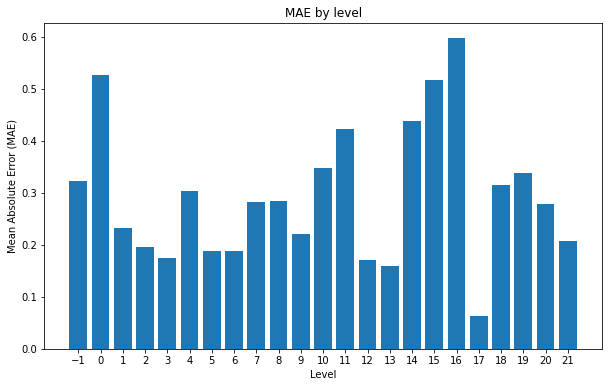

In [42]:
plot_mae_by_level(y_test_random_split, y_pred_test)

In [43]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.05
RMSE: 0.22

Round type: round
MSE: 0.05
RMSE: 0.23

Round type: 0.33
MSE: 0.08
RMSE: 0.28

Round type: 0.45
MSE: 0.05
RMSE: 0.23



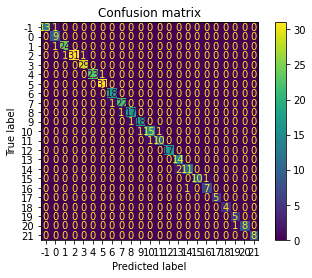

In [44]:
plot_confusion_matrix("round", predict, y_test)

## Summary

In [45]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,13,0.260888,0.510772,0.357206
1,chronological,Optuna,13,0.237582,0.487424,0.338733
2,random,normal,13,0.148111,0.384853,0.267273
3,random,Optuna,13,0.126167,0.355201,0.233126


In [46]:
from training.results import plot_summary

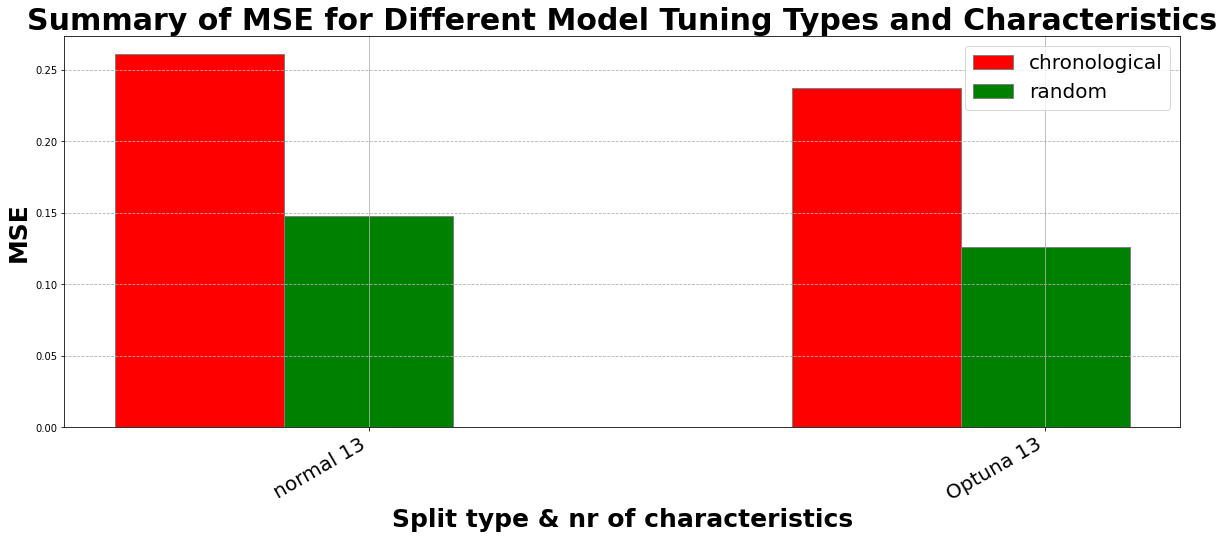

In [47]:
plot_summary(results, "MSE")

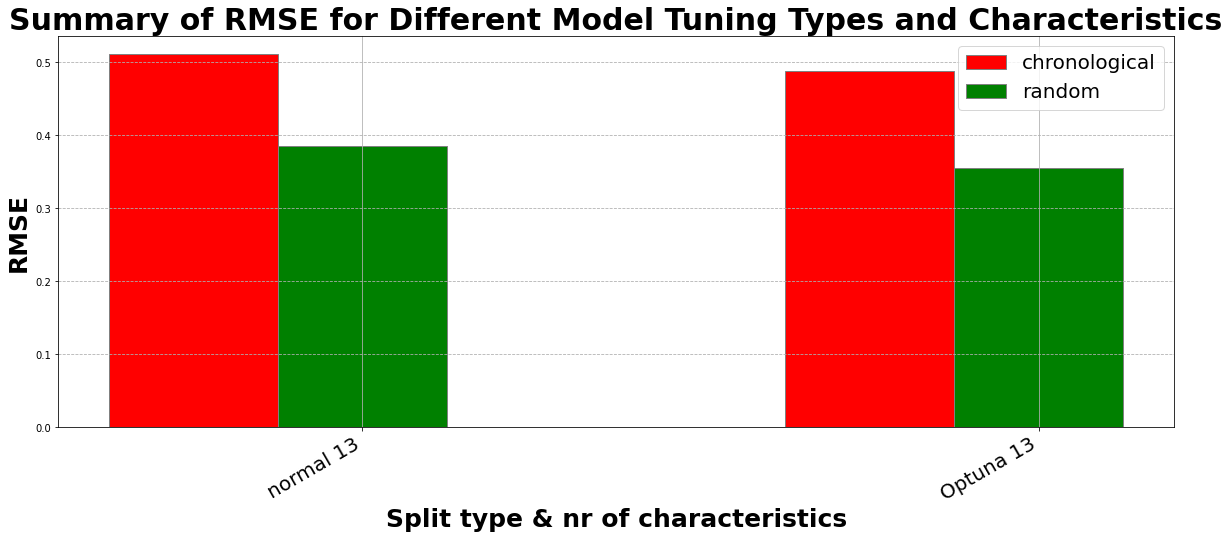

In [48]:
plot_summary(results, "RMSE")

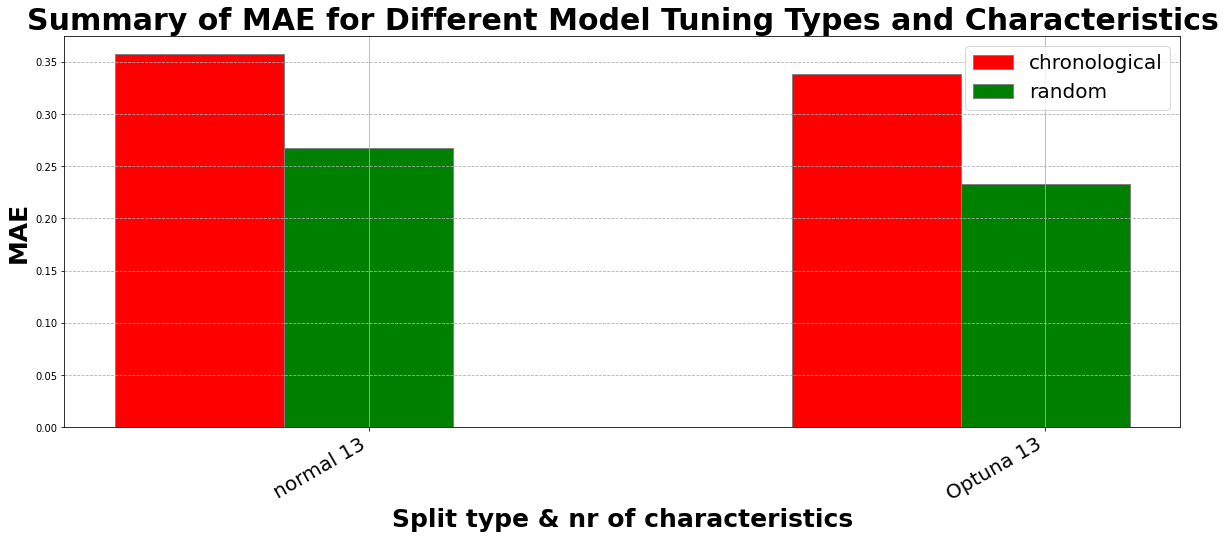

In [49]:
plot_summary(results, "MAE")

In [50]:
results.to_json("./lightgbm_second_results.json")